# Objective

## Problem to solve

Classification of diseases in plants (leaf images).

## Dataset

- https://www.tensorflow.org/datasets/catalog/plant_village

The **Plant Village** dataset is used for this project. It consists of color images of plant leaves classified into **38 categories**. Each category represents a specific `[Species]___[Disease]` pair or a `[Species]___[Healthy]` state (e.g., `Apple___Apple_scab`, `Tomato___healthy`). It is a standard benchmark dataset for multi-class image classification in agriculture.

In [1]:
from cnn_plant_health import *

# Suppress TensorFlow CUDA warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Set random seed for reproducibility
SEED = 42
keras.utils.set_random_seed(SEED)

2025-12-09 00:22:18.356243: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-09 00:22:18.391708: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-09 00:22:19.120992: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Exploratory Data Analysis

Loading Plant Village dataset into data/cnn/...


I0000 00:00:1765261339.632549   16411 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5977 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Total classes: 38
Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry___healthy', 'Cherry___Powdery_mildew', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___healthy', 'Corn___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___T

2025-12-09 00:22:20.440654: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-12-09 00:22:23.919821: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


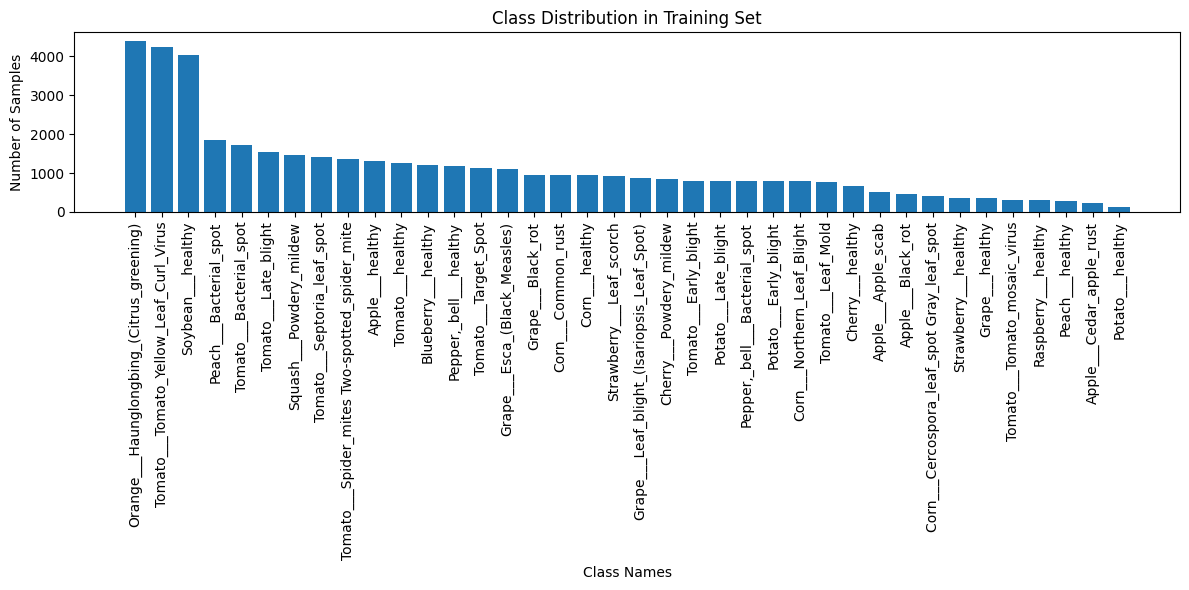

Top 5 classes by count:
  Orange___Haunglongbing_(Citrus_greening): 4399
  Tomato___Tomato_Yellow_Leaf_Curl_Virus: 4252
  Soybean___healthy: 4043
  Peach___Bacterial_spot: 1838
  Tomato___Bacterial_spot: 1732


In [2]:
data_dir = 'data/cnn/'
img_size = 256
split_ratio = 0.8

# Load dataset
print(f"Loading Plant Village dataset into {data_dir}...")

train_split = f'train[:{int(split_ratio*100)}%]'
val_split = f'train[{int(split_ratio*100)}%:]'

(train_ds, val_ds), info = tfds.load(
    'plant_village',
    split=[train_split, val_split],
    as_supervised=True,
    with_info=True,
    shuffle_files=True,
    data_dir=data_dir
)

print(f"Total classes: {info.features['label'].num_classes}")
print(f"Class names: {info.features['label'].names}")

num_classes = info.features['label'].num_classes
class_names = info.features['label'].names
input_shape = (img_size, img_size, 3)

# Perform Exploratory Data Analysis
print("Performing EDA (calculating class distribution)...")

counts = np.zeros(len(class_names), dtype=int)

# Iterate over the dataset to count labels
for _, labels in train_ds:
    unique, counts_batch = np.unique(labels.numpy(), return_counts=True)
    counts[unique] += counts_batch

# Sort by count
indices = np.argsort(counts)[::-1]
sorted_names = [class_names[i] for i in indices]
sorted_counts = counts[indices]

plt.figure(figsize=(12, 6))
plt.bar(sorted_names, sorted_counts)
plt.xlabel('Class Names')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Set')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print("Top 5 classes by count:")
for i in range(min(5, len(sorted_names))):
    print(f"  {sorted_names[i]}: {sorted_counts[i]}")

## Findings

- The dataset contains **38 distinct classes**.
- The class distribution is **imbalanced**.
    - The most frequent classes (e.g., *Orange Haunglongbing*, *Tomato Yellow Leaf Curl Virus*) contain over 4,000 images.
    - The least frequent classes contain significantly fewer samples (under 2,000).
- This imbalance implies the model might be biased towards majority classes if accuracy is the sole metric, though the dataset is large enough that even minority classes have a reasonable number of samples for training.

# Pre-processing

The data pre-processing pipeline consists of the following steps:
1.  **Resizing**: All images are resized to a fixed input shape of **256x256** pixels.
2.  **Rescaling**: Pixel values are normalized from [0, 255] to **[0, 1]**.
3.  **Data Augmentation (Training Set Only)**: To improve generalization and reduce overfitting:
    - Random Horizontal and Vertical Flips.
    - Random Rotation (factor of 0.2).
4.  **Batching & Performance**: Data is batched with a size of **32** and uses buffered prefetching (`AUTOTUNE`) to optimize I/O performance.

Visualizing data samples...


2025-12-09 00:22:25.040738: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


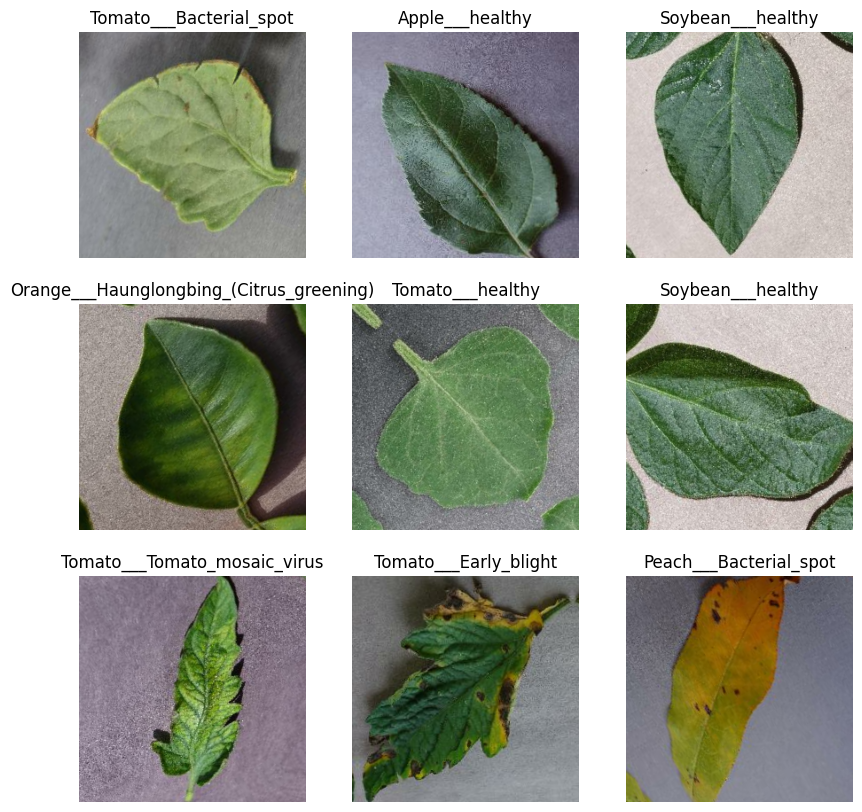

In [3]:
def preprocess_dataset(ds: tf.data.Dataset, is_training: bool, batch_size: int, img_size: int) -> tf.data.Dataset:
    resize_and_rescale = keras.Sequential([
        layers.Resizing(img_size, img_size),
        layers.Rescaling(1./255)
    ])

    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    if is_training:
        ds = ds.shuffle(1000)

    ds = ds.batch(batch_size)

    if is_training:
        data_augmentation = keras.Sequential([
            layers.RandomFlip("horizontal_and_vertical"),
            layers.RandomRotation(0.2),
        ])
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

batch_size = 32

train_ds = preprocess_dataset(train_ds, is_training=True, batch_size=batch_size, img_size=img_size)
val_ds = preprocess_dataset(val_ds, is_training=False, batch_size=batch_size, img_size=img_size)

visualize_data(train_ds, class_names)

# Model definition

## Architecture

A custom **Convolutional Neural Network (CNN)** was designed with the following structure:
-   **Input**: (256, 256, 3)
-   **Feature Extraction**: 5 Convolutional Blocks.
    -   Activation: ReLU.
-   **Classification Head**:
    -   Flatten Layer
    -   Dense Layer: 128 units, ReLU activation + Dropout.
    -   Output Layer: 38 units (num_classes), with Softmax.

In [4]:
model = keras.Sequential([
    layers.InputLayer(shape=input_shape),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,638,182 (10.06 MB)

 Trainable params: 2,638,182 (10.06 MB)

 Non-trainable params: 0 (0.00 B)

# Training

## Configuration

-   **Optimizer**: Adam
-   **Loss Function**: Sparse Categorical Crossentropy.
-   **Epochs**: 10
-   **Callbacks**:
    -   `EarlyStopping` (patience=5) to prevent overfitting.
    -   `ReduceLROnPlateau` (factor=0.2, patience=3) to fine-tune learning rate.
    -   `ModelCheckpoint` to save the best weights based on validation loss.

## Observations

-   The model training history shows it is converging.
-   By Epoch 10, the model achieved a **Validation Accuracy of ~93.17%** and a Validation Loss of **0.2157**.
-   The training and validation curves tracked closely, suggesting that the data augmentation prevented overfitting.

Epoch 1/10


2025-12-09 00:22:27.203269: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f673c00e530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-09 00:22:27.203296: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-12-09 00:22:27.251907: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-09 00:22:27.447677: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-12-09 00:22:27.532348: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-09 00:22:27.

   3/1358 ━━━━━━━━━━━━━━━━━━━━ 1:28 65ms/step - accuracy: 0.0451 - loss: 3.6421

I0000 00:00:1765261355.300928   16500 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2855 - loss: 2.6999

2025-12-09 00:23:54.857995: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_486', 8 bytes spill stores, 8 bytes spill loads



1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.2856 - loss: 2.6996

2025-12-09 00:24:00.090259: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_134', 20 bytes spill stores, 20 bytes spill loads




Epoch 1: val_loss improved from None to 1.39139, saving model to cnn_checkpoints/best.weights.h5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 103s 69ms/step - accuracy: 0.3818 - loss: 2.2482 - val_accuracy: 0.5860 - val_loss: 1.3914 - learning_rate: 0.0010
Epoch 2/10
1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5838 - loss: 1.4112
Epoch 2: val_loss improved from 1.39139 to 0.81740, saving model to cnn_checkpoints/best.weights.h5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 85s 62ms/step - accuracy: 0.6246 - loss: 1.2552 - val_accuracy: 0.7438 - val_loss: 0.8174 - learning_rate: 0.0010
Epoch 3/10
1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7121 - loss: 0.9257
Epoch 3: val_loss improved from 0.81740 to 0.53015, saving model to cnn_checkpoints/best.weights.h5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 85s 63ms/step - accuracy: 0.7365 - loss: 0.8518 - val_accuracy: 0.8305 - val_loss: 0.5301 - learning_rate: 0.0010
Epoch 4/10
1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7839 - loss: 0.6947

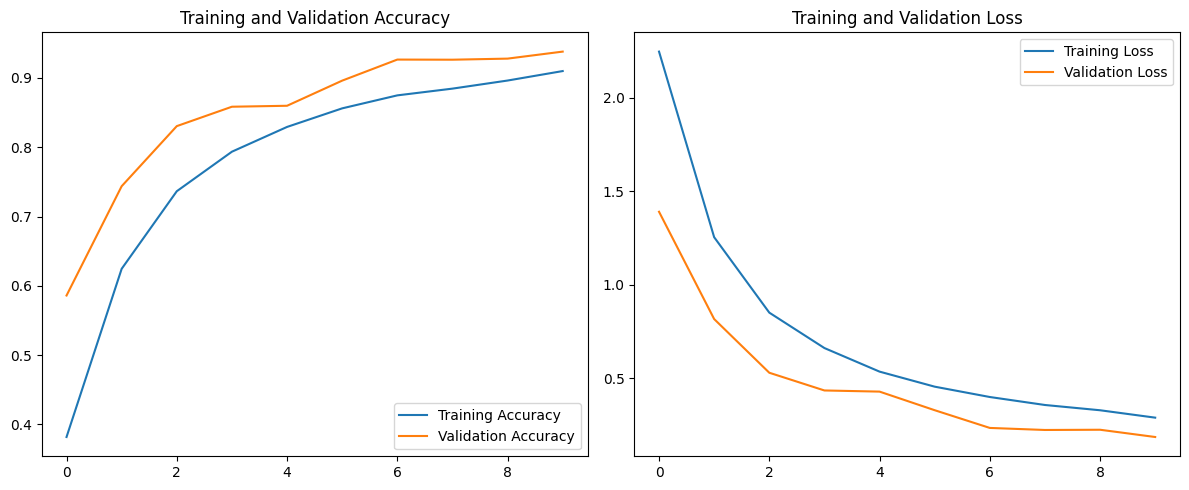

In [5]:
checkpoint_path = 'cnn_checkpoints/best.weights.h5'
epochs = 10

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

if checkpoint_path:
    checkpoint_cb = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        save_best_only=True,
        monitor='val_loss',
        verbose=1
    )
    callbacks.append(checkpoint_cb)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# Plot training history
plot_history(history)

# Evaluation and Results

The model was evaluated on the validation set (20% split).
-   **Final Metric**: ~93% Accuracy.
-   **Visual Inspection**: Qualitative analysis of model predictions shows high confidence in correct labels for randomly sampled images.

The Confusion Matrix and the Classification Report show that the majority of classes achieved F1-scores above **0.90**, which is pretty good.

However, there are a few classes with weaker results, and that could be improved:
-   `Corn___Cercospora_leaf_spot` (low recall: 0.65)
-   `Tomato___Early_blight` (low accuracy: 0.71)
-   `Potato___healthy` (low recall: 0.63)


Calculating detailed evaluation metrics...

Classification Report:
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.94      0.81      0.87       129
                            Apple___Black_rot       0.99      0.94      0.96       154
                     Apple___Cedar_apple_rust       1.00      0.87      0.93        54
                              Apple___healthy       0.89      0.95      0.92       339
                          Blueberry___healthy       0.99      0.95      0.97       292
                             Cherry___healthy       0.98      0.95      0.96       195
                      Cherry___Powdery_mildew       0.95      0.97      0.96       201
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.58      0.94      0.72       108
                           Corn___Common_rust       1.00      0.99      1.00       239
                               Corn___healthy       1.00     

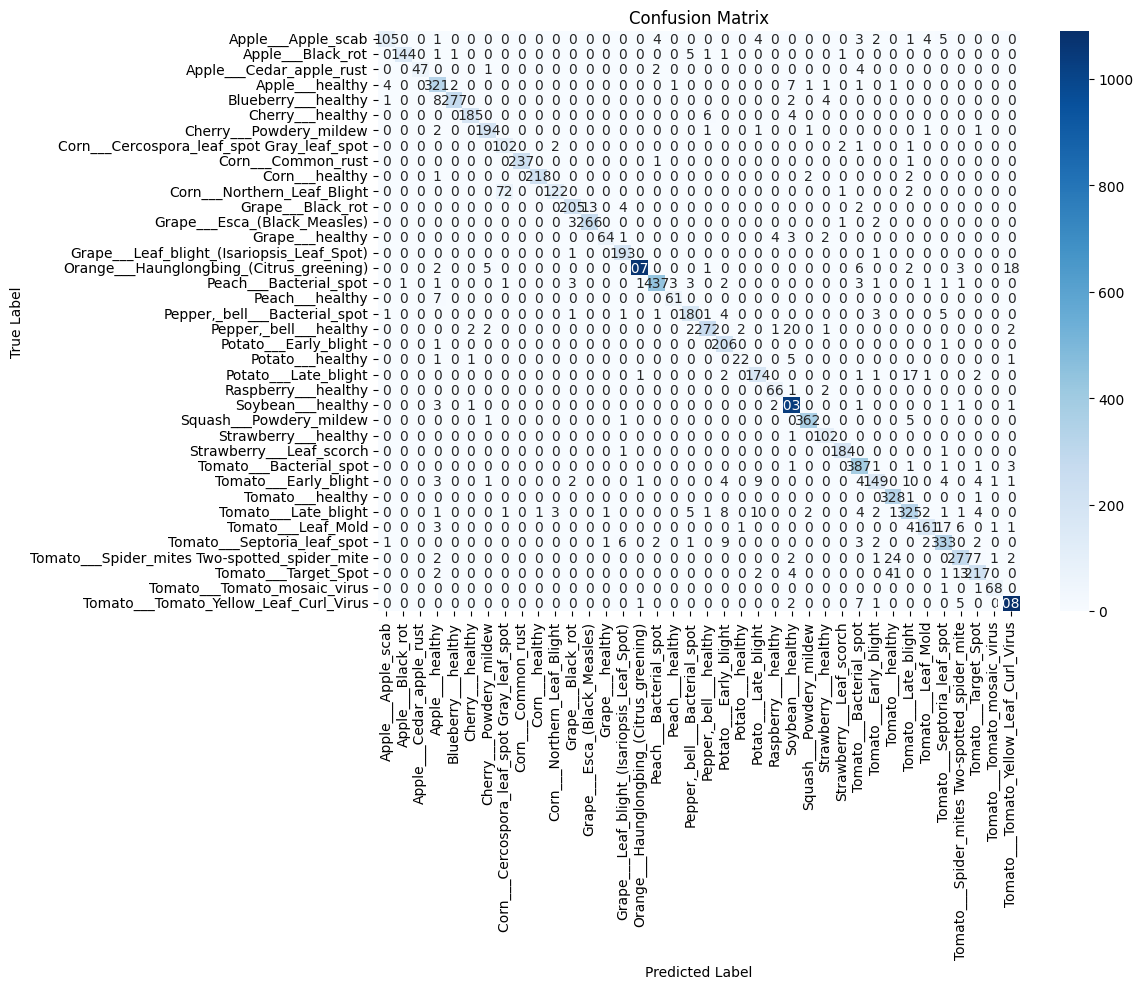


Visualizing predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


2025-12-09 00:37:19.659729: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


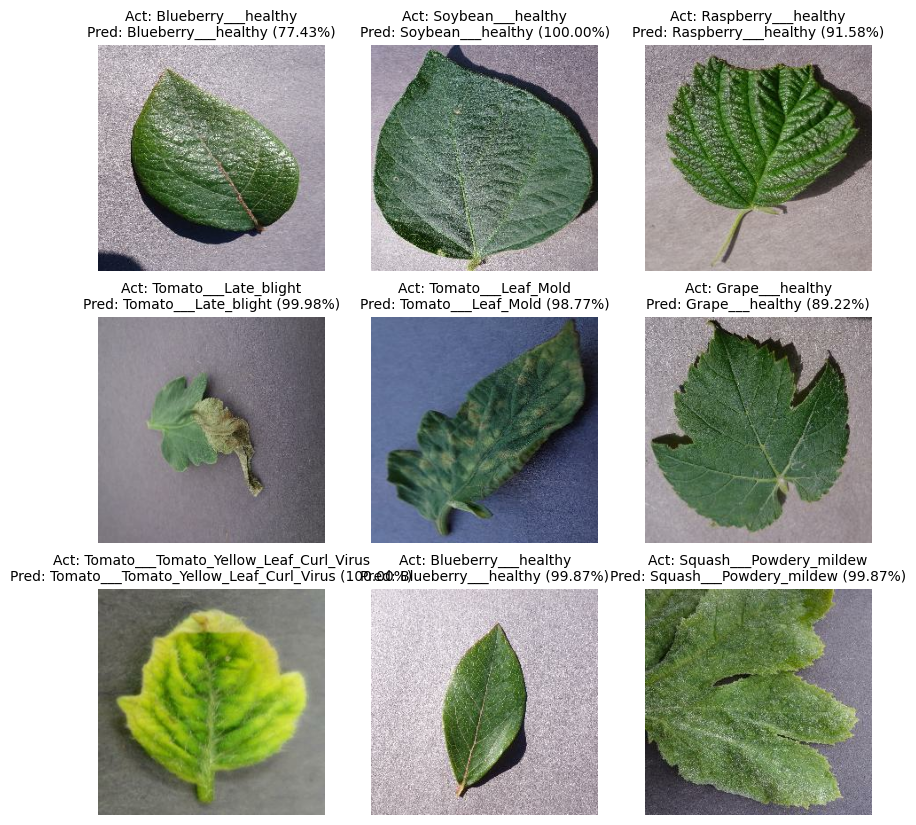

In [6]:
evaluate_model_performance(model, val_ds, class_names)
evaluate_predictions(model, val_ds, class_names)

# Analysis and Conclusions

## Interpretation of Results
The custom CNN architecture proved very effective for this task, achieving >93% accuracy in just 10 epochs. The network successfully learned to distinguish between the visual features of leaf diseases across 38 categories.

## Model Limitations
-   **Class Imbalance**: The disparity in sample counts is not being handled (e.g., via class weighting), which might affect performance on rarer diseases.
-   **Simplicity**: The model is relatively shallow (5 conv layers). While effective here, it might struggle with more complex images containing background noise, varying lighting, or multiple leaves.

## Possible Improvements
1.  **Class Weights**: Implementing class weighting during training could help balance the influence of majority vs. minority classes.
2.  **Advanced Augmentation**: Introducing brightness/contrast adjustments, and other kind of augmentations, could further improve robustness.